ミニバッチサイズ:  torch.Size([64, 3, 224, 224])
画像のチャネル数:  3
画像の高さ:  224
画像の幅:  224


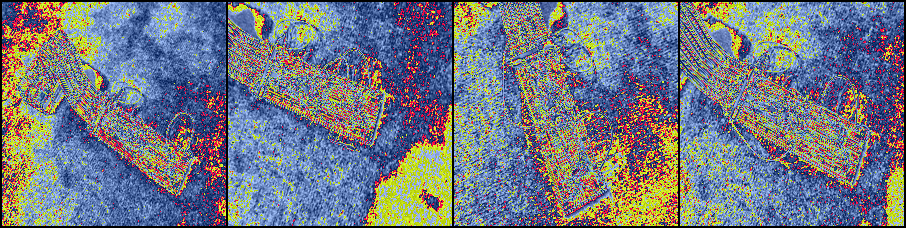

tensor([0, 1, 1, 1])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder  # 画像データセットを提供するモジュール

# 画像をテンソルに変換
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                             [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                             [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # 1チャネルから3チャネルに変換
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNetの平均
                             [0.229, 0.224, 0.225])  # ImageNetの標準偏差
    ]),
}

# 画像データセットを読み込む
full_dataset = ImageFolder(root='/Users/serenakurashina/ess4-3/Cable1_Dataset')

# ハードウェアの設定 
device = torch.device('mps')

# データセットの分割
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# 各データセットのtransformを設定
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# DataLoader の定義
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# データの確認
images, labels = next(iter(train_loader))
c, h, w = images[0].shape
print("ミニバッチサイズ: ", images.size())
print("画像のチャネル数: ", c)
print("画像の高さ: ", h)
print("画像の幅: ", w)

# グリッド上に4枚の画像を表示
img = torchvision.utils.make_grid(images[:4])
img = transforms.functional.to_pil_image(img)
display(img)

# 上の画像に対応するラベルを表示
print(labels[:4])


In [10]:
# ニューラルネットワークに入力する画像のサイズと分類するクラス数を定義
INPUT_SIZE = c * h * w
OUTPUT_SIZE = 5  # 分類するクラス数

# nn.Sequentialを使ってネットワークを定義
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(INPUT_SIZE, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, OUTPUT_SIZE),
)

# モデルをデバイスに転送
model = model.to(device)

In [11]:
# 多クラス分類のための損失関数を定義
criterion = nn.CrossEntropyLoss()

In [12]:
# モデルのパラメータを更新するための最適化手法をAdamで定義
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# モデルの学習
EPOCHS = 10
train_loss_list = []  # 訓練データの損失リスト
val_loss_list = []    # 検証データの損失リスト
train_acc_list = []   # 訓練データの精度リスト
val_acc_list = []     # 検証データの精度リスト

for epoch in range(EPOCHS):
    model.train()  # モデルを学習モードに設定
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # データをデバイスに転送
        optimizer.zero_grad()  # 勾配を初期化

        outputs = model(images)  # モデルの出力を取得
        loss = criterion(outputs, labels)  # 損失を計算

        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータを更新

        train_loss += loss.item() * images.size(0)  # 損失を蓄積（バッチサイズで重み付け）
        
        # 正解数を計算
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss /= train_total  # データ数で割って平均を取る
    train_accuracy = 100 * train_correct / train_total  # 訓練データの精度計算
    train_loss_list.append(train_loss)  # 訓練損失をリストに追加
    train_acc_list.append(train_accuracy)  # 訓練精度をリストに追加

    model.eval()  # モデルを評価モードに設定
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # 評価時は勾配を計算しない
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # データをデバイスに転送

            outputs = model(images)  # モデルの出力を取得
            loss = criterion(outputs, labels)  # 損失を計算

            val_loss += loss.item() * images.size(0)  # 損失を蓄積（バッチサイズで重み付け）

            # 正解数を計算
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total  # データ数で割って平均を取る
    val_accuracy = 100 * val_correct / val_total  # 検証データの精度計算
    val_loss_list.append(val_loss)  # 検証損失をリストに追加
    val_acc_list.append(val_accuracy)  # 検証精度をリストに追加

    print(f'Epoch {epoch+1}/{EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/10, Train Loss: 4.7671, Train Acc: 31.43%, Val Loss: 14.2214, Val Acc: 46.67%
Epoch 2/10, Train Loss: 6.2392, Train Acc: 66.43%, Val Loss: 8.3490, Val Acc: 53.33%
Epoch 3/10, Train Loss: 3.8132, Train Acc: 66.43%, Val Loss: 6.2512, Val Acc: 50.00%
Epoch 4/10, Train Loss: 3.1744, Train Acc: 64.29%, Val Loss: 3.1222, Val Acc: 73.33%
Epoch 5/10, Train Loss: 0.7936, Train Acc: 88.57%, Val Loss: 4.5570, Val Acc: 66.67%
Epoch 6/10, Train Loss: 1.5295, Train Acc: 85.71%, Val Loss: 3.2238, Val Acc: 73.33%
Epoch 7/10, Train Loss: 0.4632, Train Acc: 93.57%, Val Loss: 4.4044, Val Acc: 56.67%
Epoch 8/10, Train Loss: 0.7339, Train Acc: 84.29%, Val Loss: 2.9885, Val Acc: 73.33%
Epoch 9/10, Train Loss: 0.1860, Train Acc: 97.86%, Val Loss: 3.2037, Val Acc: 73.33%
Epoch 10/10, Train Loss: 0.3565, Train Acc: 92.86%, Val Loss: 2.6409, Val Acc: 80.00%


Confusion Matrix:
[[10  4]
 [ 2 14]]


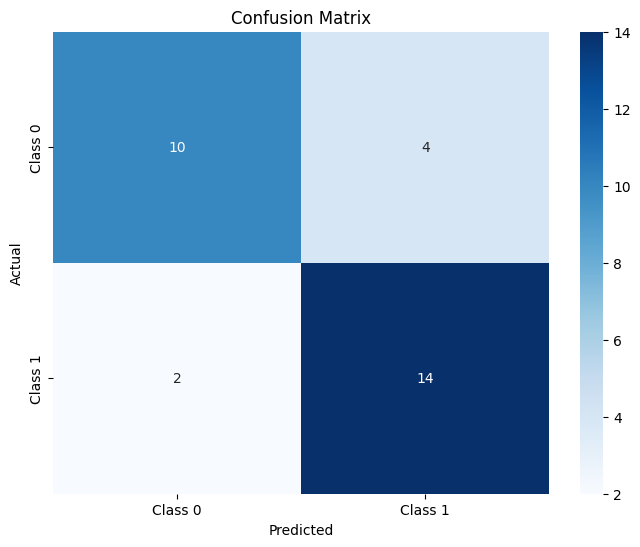

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.71      0.77        14
     Class 1       0.78      0.88      0.82        16

    accuracy                           0.80        30
   macro avg       0.81      0.79      0.80        30
weighted avg       0.80      0.80      0.80        30



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 検証データでの推論
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:  # val_loader: 検証データのDataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# クラス名とラベルを一致させる
unique_labels = sorted(set(all_labels))  # 出現するクラスラベルを取得
if 'class_names' not in globals() or len(class_names) != len(unique_labels):
    class_names = [f"Class {i}" for i in unique_labels]  # 自動生成（例: "Class 0", "Class 1", ...）

# 混同行列の作成
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1スコアのレポート
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(report)


In [15]:
# モデルの評価
model.eval() # モデルを評価モードに設定
correct = 0 # 正解数
total = 0 # テストデータの総数
with torch.no_grad():
    for images, labels in test_loader: # テストデータを取得
        images, labels = images.to(device), labels.to(device) # データをハードウェアに転送
        outputs = model(images) # 画像をモデルに入力して出力を取得
        _, predicted = torch.max(outputs, 1) # 確率が最大のラベルを取得=モデルによる予測結果を取得
        total += labels.size(0) # labels.size(0)はミニバッチサイズ、毎回加算することでテストデータの総数を計算
        correct += (predicted == labels).sum().item() # 予測と正解ラベルが一致した場合に正解数をカウント
# 正解率を%で表示
print(f'Accuracy: {correct / total * 100:.2f}%')

Accuracy: 70.00%


In [16]:
# 学習済みの重みを保存
# model.state_dict(): モデルの重みを格納したオブジェクト
torch.save(model.state_dict(), "kadai5.pth")